In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math


# Global Variables
NUM_ROW = 5
NUM_COL = 9
TARGET_POS = ([[0,0],[0,500],[900,0],[900,500]])
MAP_FILE_NAME = "../MapBuilt.txt"
ROBOT_RAD = 22
CYAN = [(0, 150, 150), (35, 255, 255)]
PINK = [(150, 0, 150), (255, 35, 255)]
ROBOT_RANGE = [(23, 2, 0), (88, 178,255)]
RGB_BLUE = (0, 0, 255)
RGB_GREEN = (0, 255, 0)

MAZE_FILE_NAME = "../Maze.png"
ROBOT_FILE_NAME = "../Robot.png"
IMAGE_LADYBUG_FILE_NAME = "../Ladybug_small.png"

# Functions
def read_image(name):
    img_bgr = cv2.imread(name)
    if img_bgr is not None:
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        return img_bgr, img_rgb
        
def find_corners(img_rgb, colour_range, outline):
    # create a mask
    mask = cv2.inRange(img_rgb, colour_range[0], colour_range[1])

    # find contours within mask
    
    contours = getContours(mask)
    # find the Enclosing circle
    coords = []
    for i in range (0, len(contours), 1):
        (x,y), radius = cv2.minEnclosingCircle(contours[i])
        cv2.circle(img_rgb, (int(x), int(y)), int(radius), outline, 5)   
        coords.append([int(x),int(y)])
    return img_rgb, coords

def getContours(image, retr = cv2.RETR_EXTERNAL):
    #retr uses external as default and tree for wall locating
    contours = cv2.findContours(image, retr, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    return contours

def sort_coordinates(coordinates):
    dist = []
    pink_corner = coordinates[3]
    for coord in coordinates[:3]:
        temp = math.sqrt((pink_corner[0] - coord[0])**2 + (pink_corner[1] - coord[1])**2)
        dist.append(temp)
    sorted_dist = sorted(dist)
    sorted_coords = []

    for i in range(len(sorted_dist)-1, -1, -1):
        sorted_coords.append(coordinates[dist.index(sorted_dist[i])])
    sorted_coords.append(coordinates[3])
    return sorted_coords
    
def transform_image(img_rgb, sorted_coords):

    target = np.float32(TARGET_POS)
    sorted_coords = np.float32(sorted_coords)
    H = cv2.getPerspectiveTransform(sorted_coords, target)
    img = cv2.warpPerspective(img_rgb, H, (900, 500))

    return img
    
def draw_walls(img, contours):

    #Finds the location of each point between walls, will be used later for txt file
    walls = []; 
    for i in range(0, len(contours)):
        wall = []    
        if len(contours[i] > 50):
            for c in range (0, len(contours[i])):
                #drawing walls on BOUNDARY of cells in transformed perspective
                x_int = round(contours[i][c][0][0] / 100) 
                y_int = round(contours[i][c][0][1] / 100)
                point = [x_int*100, y_int*100]
                if (len(wall) > 0):
                    if point != wall[len(wall)-1] :
                        wall.append(point)
                else:
                    wall.append(point)
        if len(wall) > 1:
            walls.append(wall)
    
    #Draw the walls on image
    for line in walls:
        for i in range(0, len(line)-1):
            cv2.line(img, (line[i][0], line[i][1]), (line[i+1][0], line[i+1][1]), (0, 0, 255), 4)
    
    return img, walls
    
def getRobotCentre(contours):
    centre = []
    rad = 0
    for contour in contours:
        (x,y), rad = cv2.minEnclosingCircle(contour)
        if (rad > 20):
            centre = [x,y]
    return centre, rad

def transformRobotHeading(m_corner, rad, centre):

    #Finds the centre of the Marker in Robot.png
    minX = 0
    maxX = 0
    minY = 0
    maxY = 0
    for coord in m_corner[0][0]:
        if (minX == 0 and minY == 0):
            minX = coord[0]
            minY = coord[1]
        else:
            if (minX > coord[0]):
                minX = coord[0]
            if (minY > coord[1]):
                minY = coord[1]
        if (coord[0] > maxX):
            maxX = coord[0]
        if (coord[1] > maxY):
            maxY = coord[1]

    closeX = (maxX - minX)/2 + minX
    closeY = (maxY - minY)/2 + minY
    close_centre = [closeX, closeY]
    
    corners = []
    ratio = rad/225

    #Finds the translated location of each corner of the marker in Maze.png
    for corner in m_corner[0][0]:
        if (corner[0] < close_centre[0]):
            x = close_centre[0] -corner[0]
        else :
            x = close_centre[0] + corner[0]
        if  (corner[1] < close_centre[1]):
            y = close_centre[1] - corner[1]
        else :
            y = close_centre[1] + corner[1]
        x *= ratio
        y *= ratio
        corners.append([x + centre[0], y + centre[1]])

    return corners

def getMarkerDistance(sorted_coords, corners):
    #Finding the shortest distance from point on marker to lines connected to pink dot
    try:
        m1 = (sorted_coords[1][1] - sorted_coords[3][1])/(sorted_coords[1][0] - sorted_coords[3][0])
    except:
        m1 = 0

    try:
        m2 = (sorted_coords[2][1] - sorted_coords[3][1])/(sorted_coords[2][0] - sorted_coords[3][0])
    except:
        m2 = 0

    x1 = sorted_coords[3][0]
    y1 = sorted_coords[3][1]
    distance_W = []
    distance_N = []

    #calculation distance from the lines in EW and NS directions
    #Uses line equation ax + by + c = 0 
    if (m1 != 0 and m2 != 0):
        a1 = m1
        a2 = m2
        c1 = -m1*x1 + y1
        c2 = -m2*x1 + y1
        for coord in corners:
            distance_N.append(abs(a1*coord[0] - coord[1] + c1)/math.sqrt(a1**2 + 1))        
            distance_W.append(abs(a2*coord[0] - coord[1] + c2)/math.sqrt(a2**2 + 1))
    else:
        for coord in corners:
            distance_W.append(abs(coord[0] - x1))
            distance_N.append(abs(coord[1] - y1))

    return distance_W, distance_N

def NS_or_EW(distance_W, distance_N):
    #Locates the heading of the Robot by checking East and West First, then North and South
    sorted_distance_W = sorted(distance_W)
    sorted_distance_N = sorted(distance_N)
    
    heading = getHeading(distance_W, sorted_distance_W, 'E', 'W')
    #if not East or West, Checking North or South
    if (heading == ''):
        heading = getHeading(distance_N, sorted_distance_N, 'S', 'N')   
    
    return heading

def getHeading(distances, sorted_distances, direction1, direction2):
    #checks if it is the closest or most distance point from line 
    #E.g if checking East - West, Closest suggests facing East, Furthest indicates West
    if distances[0] == sorted_distances[0]:
        return direction1
    elif distances[0] == sorted_distances[3]:
        return direction2
    else:
        return ''

def displayRobot(img_trans, contours, heading):
    direction = ""
    robot_location = []
    for contour in contours:
        x,y,w,h = cv2.boundingRect(contour)
        # limits the dimensions of the contour by size to ensure robot is properly located and displayed
        if(w > 20 and h > 20 and w < 100 and h < 100):
            x = int((x+w/2)/100)+0.5
            y = int((y+h/2)/100)+0.5
            x = int(x * 100)
            y = int(y * 100)
            robot_location = [y,x]
            cv2.circle(img_trans, (x, y), ROBOT_RAD, (255,0,0), 2)
            partV, direction = display_heading(img_trans, x, y, heading)
   
    return partV, direction, robot_location
    
def display_heading(img, x, y, heading):
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = ''
    # Flag flips the 'v' upside down for better direction indication for North
    flag = False
    if (heading == 'E'):
        x -= 10
        text = '>'
    elif (heading == 'W'):
        x -= 10
        text = '<'
    elif (heading == 'N'):
        text = 'v'
        x -= 7
        y -= 18
        flag = True
    else:
        x -= 7
        text = 'v'    
    
    cv2.putText(img, text, (x-5, y+10), font, 1.2, (255,0,0), 2, cv2.LINE_AA, flag)
    if flag == True: 
        text = '^'
    return img, text

def make_empty_map():
    #Makes an empty map based on Number of rows and Number of columns in maze
    map = []
    for x in range(0, NUM_ROW):
        current_horiz = []
        current_vert = []
        # NUM_COL * 4 + 1 is the number of characters in One line of the text based maze
        for y in range(0, NUM_COL*4 + 1): 
            if (y > 0 and y < NUM_COL*4):
                current_vert.append(" ")
            else:
                current_vert.append("|")
            if (x > 0):
                current_horiz.append(" ")
            else :
                if (y%4 != 0):
                    current_horiz.append("-")
                else:
                    current_horiz.append(" ")

        map.append(current_horiz)
        map.append(current_vert)
        if (x == NUM_ROW - 1):
            current_horiz = []
            for i in range (NUM_COL*4 + 1):
                if (i%4 != 0):
                    current_horiz.append("-")
                else:
                    current_horiz.append(" ")
            map.append(current_horiz)
    return map

def build_map(map, walls, robot_location, target_loc, direction):
    #Indicating internal Walls
    for i in range(0, len(walls)):
        for c in range(0, len(walls[i])-1):
            x = y = 0
            x_idx = y_idx = 0
            if (walls[i][c][0] < walls[i][c+1][0]):
                x = int(walls[i][c][0]/100)
                y = int(walls[i][c][1]/100)
                x_idx = 4 * x +1
                y_idx = y*2
                map[y_idx][x_idx] = map[y_idx][x_idx + 1] = map[y_idx][x_idx + 2] = "-"
            elif (walls[i][c][0] > walls[i][c+1][0]):
                x = int(walls[i][c+1][0]/100)
                y = int(walls[i][c+1][1]/100)
                x_idx = 4 * x +1
                y_idx = y*2
                map[y_idx][x_idx] = map[y_idx][x_idx + 1] = map[y_idx][x_idx + 2] = "-"
            elif (walls[i][c][1] < walls[i][c+1][1]):
                x = int(walls[i][c][0]/100)
                y = int(walls[i][c][1]/100)
                y_idx = y*2 + 1
                x_idx = x*4
                map[y_idx][x_idx] = "|"
            
            elif (walls[i][c][1] > walls[i][c+1][1]):
                x = int(walls[i][c+1][0]/100)
                y = int(walls[i][c+1][1]/100)
                y_idx = y*2 + 1
                x_idx = x*4
                map[y_idx][x_idx] = "|"
            
    #Indicating Robot
    rob_x_idx = int(robot_location[1]/100) * 4 + 2
    rob_y_idx = int(robot_location[0]/100) * 2 + 1
    map[rob_y_idx][rob_x_idx] = direction

    #Indicating Target
    targ_x_idx = int(target_loc[0]/100) * 4 + 2
    targ_y_idx = int(target_loc[1]/100) * 2 + 1

    map[targ_y_idx][targ_x_idx] = "x"
    return map

def find_Target(img_LB, LB_hsv, partV, img_HSV):
    
    #Masking ladyBug_small.png and Maze.png for comparison
    mask = cv2.inRange(LB_hsv, (0, 0, 0), (1, 255,220))  + cv2.inRange(LB_hsv, (170, 0 ,0), (179, 255, 220)) 
    masking = cv2.bitwise_and(img_LB, img_LB, mask=mask)   

    mask2 =cv2.inRange(img_HSV, (106, 3, 148), (179, 246,255))
    masking2 = cv2.bitwise_and(partV, partV, mask=mask2)

    #Finding all matching features between LadyBug_small.png and Maze.png
    surf = cv2.xfeatures2d.SURF_create()

    kp1, des1 = surf.detectAndCompute(masking, None)
    kp2, des2 = surf.detectAndCompute(masking2, None)

    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

    matches = bf.match(des1, des2)
    matches = sorted(matches, key = lambda x:x.distance)
    
    #Converting matching locations into maze indices, e.g. [0,1]
    location = []
    for match in matches:
        x = int(kp2[match.queryIdx].pt[0]/100) + 0.5
        y = int(kp2[match.queryIdx].pt[1]/100) + 0.5
        location.append([int(x*100), int(y*100)])
    
    #Locating target based on mode (most occuring maze index)
    target_loc = []
    num_occurrences = 0 
    for point in location:
        freq = location.count(point)
        if freq > num_occurrences:
            num_occurrences = freq
            target_loc = point

    return target_loc

def taskOne():
    img_bgr, img_rgb = read_image(MAZE_FILE_NAME)
    plt.imshow(img_rgb)
    plt.show()
    return img_bgr, img_rgb

def taskTwo(img_rgb):
    img_hsv = cv2.cvtColor(cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR), cv2.COLOR_BGR2HSV)
    img_rgb, coordinates = find_corners(img_rgb, CYAN, RGB_BLUE)
    img_rgb, temp_coord = find_corners(img_rgb, PINK, RGB_GREEN)
    coordinates.append(temp_coord[0])
    # show image
    plt.imshow(img_rgb)
    plt.show()

    return img_hsv, img_rgb, coordinates

def taskThree(img_corners, coordinates):
    sorted_coords = sort_coordinates(coordinates)
    img_trans = transform_image(img_corners, sorted_coords)
    plt.imshow(img_trans)
    plt.show()

    return sorted_coords, img_trans
    
def taskFour(img_trans):
    img_trans_BGR = cv2.cvtColor(img_trans, cv2.COLOR_RGB2BGR)
    img_trans_HSV = cv2.cvtColor(img_trans_BGR, cv2.COLOR_BGR2HSV)

    #locating only the walls
    mask = cv2.inRange(img_trans_HSV, (18, 74 , 212), (19, 116, 255))
    masking = cv2.bitwise_and(img_trans, img_trans, mask=mask)

    # erode
    kernel = np.ones((2,2), np.uint8)
    erosion = cv2.erode(mask, kernel, iterations=1)

    # dilate
    kernel = np.ones((3,3), np.uint8)
    dilation = cv2.dilate(erosion, kernel, iterations = 3)

    contours = getContours(dilation, cv2.RETR_TREE)

    img_walls, walls = draw_walls(img_trans, contours)    #Drawing walls onto image and storing wall locations for MapBuilt.txt
    

    plt.imshow(img_walls)
    plt.show()

    return img_walls, walls, img_trans_HSV
    
def taskFive(img_hsv, img_trans_HSV, img_trans, sorted_coords):
    
    rob_bgr, img_rob = read_image(ROBOT_FILE_NAME)
    
    #Find Robot in original image
    mask2 =cv2.inRange(img_hsv, ROBOT_RANGE[0], ROBOT_RANGE[1]) 
    kernel = np.ones((3,3), np.uint8)
    dilation = cv2.dilate(mask2, kernel, iterations = 2)
    contours = getContours(dilation)
    centre, rad = getRobotCentre(contours)

    #Find corners of Robot Marker
    dict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_6X6_250)
    params = cv2.aruco.DetectorParameters_create()
    m_corner, m_ids, rej_cand = cv2.aruco.detectMarkers(img_rob, dict, parameters=params)

    corners = transformRobotHeading(m_corner, rad, centre)

    distance_W, distance_N = getMarkerDistance(sorted_coords, corners)

    heading = NS_or_EW(distance_W, distance_N)

    #location the robot on the transformed image
    mask2 =cv2.inRange(img_trans_HSV, ROBOT_RANGE[0], ROBOT_RANGE[1]) 

    # dilate
    kernel = np.ones((3,3), np.uint8)
    dilation = cv2.dilate(mask2, kernel, iterations = 2)

    contours = getContours(dilation)

    #Marking the robot on the transformed image 
    partV, direction, robot_location = displayRobot(img_trans, contours, heading)
    plt.imshow(partV)
    plt.show()

    return partV, direction, robot_location

def taskSix(img_final, img_HSV):
    LB_brg, img_LB = read_image(IMAGE_LADYBUG_FILE_NAME)
    LB_hsv = cv2.cvtColor(LB_brg, cv2.COLOR_BGR2HSV)

    target_loc = find_Target(img_LB, LB_hsv, img_final, img_HSV)

    #Mark target
    cv2.circle(img_final, (target_loc[0], target_loc[1]), 20, (0, 255, 0), 3)
    cv2.putText(img_final, "x", (target_loc[0]-10, target_loc[1]+10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0,255,0), 3, cv2.LINE_AA)

    plt.imshow(img_final)
    plt.show()

    return target_loc

def taskSeven(walls, robot_location, target_location, direction):
    map = build_map(make_empty_map(), walls, robot_location, target_location, direction)

    counter = 0
    with open(MAP_FILE_NAME, 'w') as f:
        for i in map:
            line = ""
            for c in i:
                line = line + c
            f.write(line)
            if (counter < 10):
                f.write('\n')
            counter += 1
    f.close()

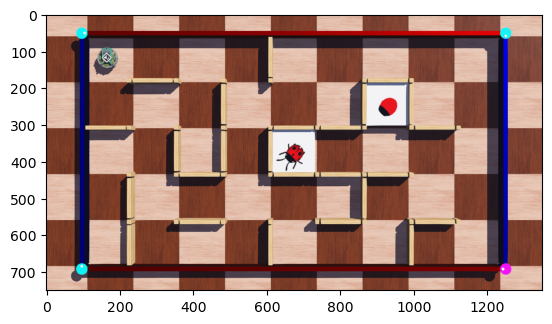

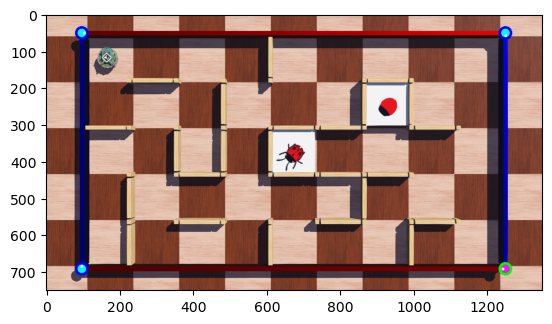

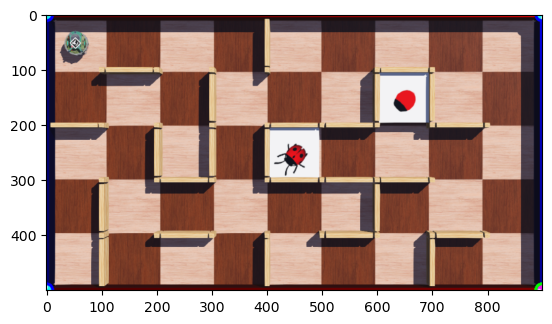

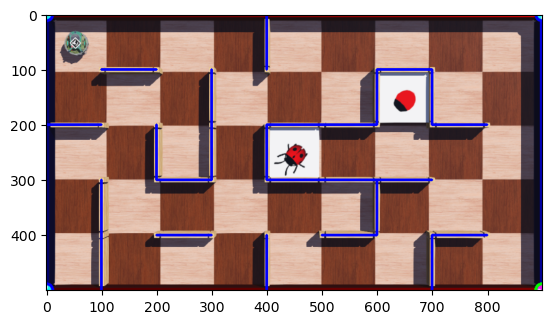

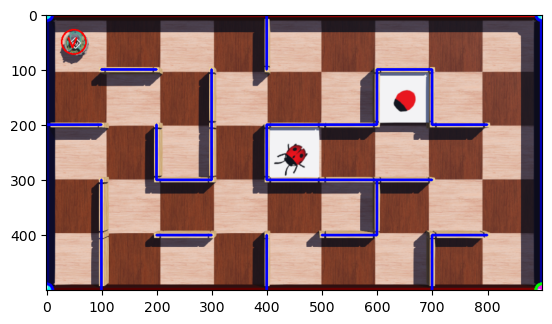

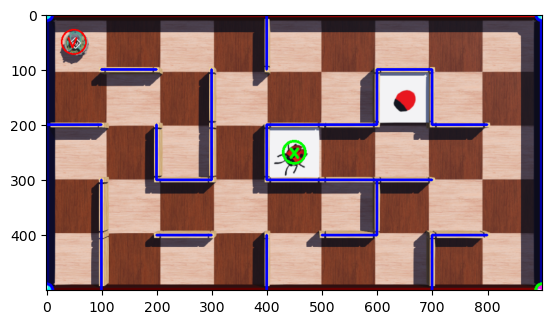

In [12]:
# Running Tasks
if __name__ == '__main__':
    img_bgr, img_rgb = taskOne()
    img_hsv, img_corners, coordinates = taskTwo(img_rgb)
    sorted_coords, img_trans = taskThree(img_corners, coordinates)
    img_walls, walls, img_trans_HSV = taskFour(img_trans) 
    img_final, direction, robot_location = taskFive(img_hsv, img_trans_HSV, img_walls, sorted_coords)
    target_location = taskSix(img_final, img_trans_HSV)
    taskSeven(walls, robot_location, target_location, direction)